In [1]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import os
import torch
import timm
import torchvision.transforms as transforms
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


/cluster/home/taheeraa/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Bounding boxes and XAI within Chest X-Ray14 dataset

Want to add gradcam to alexnet baseline and compare them to the bounding boxes in the dataset.

In [2]:
root_folder = '/cluster/home/taheeraa/datasets/chestxray-14/'
images_path = f"{root_folder}images/"
file_path_bbox = root_folder + 'BBox_List_2017.csv'

num_labels = 14

labels = [
        "Atelectasis", 
        "Cardiomegaly",
        "Effusion", 
        "Infiltration", 
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",  
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia"
    ]
num_labels = len(labels) 

df_bbox = pd.read_csv(file_path_bbox)
df_bbox.head()

file_path_data_entry = root_folder + 'Data_Entry_2017.csv'
df_data_entry = pd.read_csv(file_path_data_entry)
df_data_entry.head()

merged_df = pd.merge(df_bbox, df_data_entry, on='Image Index', how='inner')
merged_df.rename(columns={
    'Bbox [x': 'x',
    'h]': 'h',
}, inplace=True)
merged_df['filepath'] = images_path + merged_df['Image Index']
merged_df.head()

image_index_counts = merged_df.groupby('Image Index').size()

# Convert to DataFrame for better handling and sort
image_index_counts_df = image_index_counts.reset_index(
    name='Count').sort_values(by='Count', ascending=False)
image_index_counts_df.head(20)

,Image Index,Count
204,00010277_000.png,4
516,00018427_004.png,3
327,00013659_019.png,3
598,00020482_032.png,3
220,00010828_039.png,3
279,00012376_010.png,3
633,00021703_001.png,3
113,00005066_030.png,3
506,00018253_059.png,3
170,00008814_010.png,3


Here one can see that some images has more than one bbox related to the images

/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png


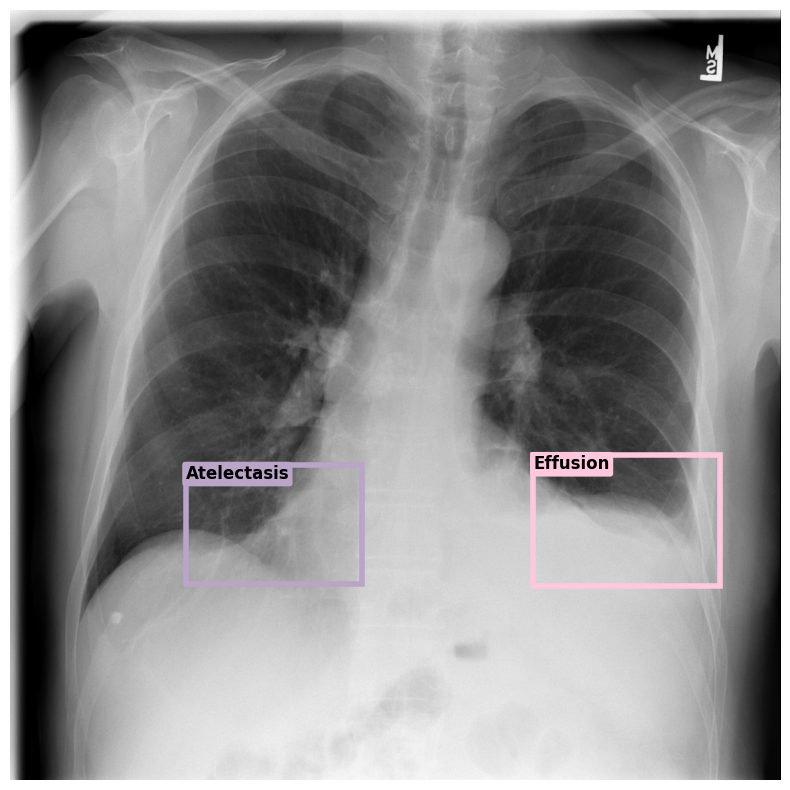

'/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png'

In [4]:
img_id = "00010575_002"
img_index = f"{img_id}.png"
base_path = "/cluster/home/taheeraa/datasets/chestxray-14/images/"
img_path = f"{base_path}{img_index}"
print(img_path)

df_filtered = merged_df[merged_df['Image Index'] == img_index]

# Define specific colors
colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
unique_labels = df_filtered['Finding Label'].unique()
if len(unique_labels) > len(colors_list):
    print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
label_color_map = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

# Open the image
img = Image.open(img_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

# First subplot: Image with bounding boxes
ax1 = axs
ax1.imshow(img, cmap='gray')

# Draw each bounding box with its corresponding label
for idx, row in df_filtered.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    label = row['Finding Label']
    color = label_color_map[label]
    rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor=color, facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold', 
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

ax1.axis('off')
plt.show(f"xai/swin/{img_id}.png")
img_path

# model

In [5]:
base = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/06-transformers-pre-trained/"
pretrained_weights = base + "swin_base_imagenet_1k_sgd_64_bce_aug/model.pth.tar"

experiment_name = os.path.basename(os.path.dirname(pretrained_weights))
model_str = experiment_name.split('_')[0]
print(experiment_name, model_str)

model = timm.create_model(
                    'swin_base_patch4_window7_224_in22k', num_classes=num_labels, pretrained=True)
    
checkpoint = torch.load(pretrained_weights, map_location="cpu")
print(checkpoint.keys())

state_dict = checkpoint['state_dict']
msg = model.load_state_dict(state_dict, strict=False)
print('Loaded with msg: {}'.format(msg))
print(img_path)

swin_base_imagenet_1k_sgd_64_bce_aug swin


/cluster/home/taheeraa/.local/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


dict_keys(['epoch', 'lossMIN', 'state_dict', 'optimizer', 'scheduler'])
Loaded with msg: <All keys matched successfully>
/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png


## prepare data

In [6]:
def load_and_preprocess_images(image_path, normalize="chestx-ray"):
    if normalize.lower() == "imagenet":
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    elif normalize.lower() == "chestx-ray":
        normalize = transforms.Normalize([0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])
        
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to the same size expected by the model
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Convert the image to a tensor
        normalize
    ])
    images = transform(Image.open(image_path).convert('RGB'))
    return images.unsqueeze(0)
                       
input_tensor = load_and_preprocess_images(img_path)
print(img_path)
input_tensor.size()

/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png


torch.Size([1, 3, 224, 224])

## model inference

In [7]:
def predict(model, batch):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        logits = model(batch)  # Forward pass
        probabilities = torch.sigmoid(logits)  # Convert logits to probabilities for multilabel classification
    return probabilities

# Perform inference
probabilities = predict(model, input_tensor)
predicted_labels = [labels[idx] for idx, is_predicted in enumerate((probabilities > 0.2).squeeze()) if is_predicted]
print(predicted_labels)
img_path

['Atelectasis', 'Effusion']


'/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png'

In [ ]:
model.eval()
target_layers = [model.layers[-1].blocks[-1].norm2]

def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


In [ ]:
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

methods = {"gradcam": GradCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad
}

cam = methods["gradcam"](model=model,
                                   target_layers=target_layers,
                                   reshape_transform=reshape_transform)

In [ ]:
print(img_path)
rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255

/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png


In [ ]:
cam.batch_size = 32

grayscale_cam = cam(input_tensor=input_tensor,
    targets=None,
    eigen_smooth=True,
    aug_smooth=False)

print(img_id)
grayscale_cam = grayscale_cam[0, :]

cam_image = show_cam_on_image(rgb_img, grayscale_cam)
cv2.imwrite(f'xai/swin/{img_id}_grad_cam_in.jpg', cam_image)

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 805: MPS client failed to connect to the MPS control daemon or the MPS server (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


00010575_002


True

In [12]:
import torch.nn as nn

class LRPModel(nn.Module):
    def __init__(self, model):
        super(LRPModel, self).__init__()
        self.model = model

    def forward(self, x):
        self.activations = []
        self._store_activations(self.model, x)
        return self.model(x)

    def _store_activations(self, module, input):
        self.activations.append(input)
        for name, sub_module in module.named_children():
            input = sub_module(input)
            self.activations.append(input)

    def relprop(self, R):
        for module in reversed(list(self.model.children())):
            R = module.relprop(R)
        return R

# Wrap the Swin Transformer model
lrp_model = LRPModel(model)


import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom relevance propagation for linear layers
class LinearLRP(nn.Linear):
    def relprop(self, R):
        Z = self.weight @ self.input.T + self.bias[:, None]
        S = R / Z
        C = S @ self.input
        return C.T

# Custom relevance propagation for convolutional layers
class Conv2dLRP(nn.Conv2d):
    def relprop(self, R):
        Z = F.conv2d(self.input, self.weight, self.bias, self.stride, self.padding)
        S = R / Z
        C = F.conv_transpose2d(S, self.weight, stride=self.stride, padding=self.padding)
        return C

# Custom relevance propagation for other layers can be similarly defined

# Wrap the Swin Transformer model
def replace_layers(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            setattr(model, name, LinearLRP(module.in_features, module.out_features))
        elif isinstance(module, nn.Conv2d):
            setattr(model, name, Conv2dLRP(module.in_channels, module.out_channels, module.kernel_size, module.stride, module.padding))
        else:
            replace_layers(module)


# Replace layers with custom layers
replace_layers(model)

lrp_model = LRPModel(model)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def generate_relevance_map(model, input_image):
    model.eval()
    
    # Forward pass
    output = model(input_image)
    
    # Initialize relevance as the output
    R = output.clone()
    
    # Backward pass to propagate relevance
    R = model.relprop(R)
    
    # Get the relevance of the input image
    relevance_map = R.detach().numpy()
    
    return relevance_map

def plot_relevance_map(relevance_map, input_image):
    relevance_map = np.squeeze(relevance_map)
    input_image = np.squeeze(input_image.detach().numpy())

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(np.transpose(input_image, (1, 2, 0)))
    ax[0].set_title("Input Image")

    ax[1].imshow(relevance_map, cmap='hot', interpolation='nearest')
    ax[1].set_title("Relevance Map")

    plt.show()


# Generate relevance map
relevance_map = generate_relevance_map(lrp_model, input_tensor)

# Plot the relevance map
plot_relevance_map(relevance_map, input_tensor)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (49x1 and 1024x14)